# The Goal

The Matplotlib based Tomograph proves to be a useful tool to investigate and debug optimizers' outputs. But it is slow, unwieldy, and far from beautiful.

The goal of this document and the broader effort, is to beef up the Tomograph to make it more user friendly and more configurable.

# Strategy
Let's instantiate an optimizer and a corresponding ModelTomograph - since it will do most of the heavy lifting for us in terms of talking to the Optimizer, serializing/deserializing requests, etc. We can then monkey patch the plotly functionality onto that Tomograph

In [1]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from mlos.OptimizerEvaluationTools.SyntheticFunctions.Flower import Flower
from mlos.OptimizerEvaluationTools.SyntheticFunctions.ThreeLevelQuadratic import ThreeLevelQuadratic
from mlos.Optimizers.BayesianOptimizerFactory import BayesianOptimizerFactory
from mlos.Optimizers.OptimizationProblem import OptimizationProblem, Objective
from mlos.OptimizerMonitoring.Tomograph.ModelTomograph import ModelTomograph


objective_function = Flower()
objective_name = objective_function.output_space.dimensions[0].name

optimization_problem = OptimizationProblem(
    parameter_space=objective_function.parameter_space,
    objective_space=objective_function.output_space,
    objectives=[Objective(name=objective_name, minimize=True)] 
)

optimizer = BayesianOptimizerFactory().create_local_optimizer(optimization_problem=optimization_problem)

01/10/2021 03:42:22 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizerFactory.py:  37 -    create_local_optimizer() ] Optimizer config not specified. Using default.


{
  "x1": 84.48699869208548,
  "x2": -56.98051353286182
}


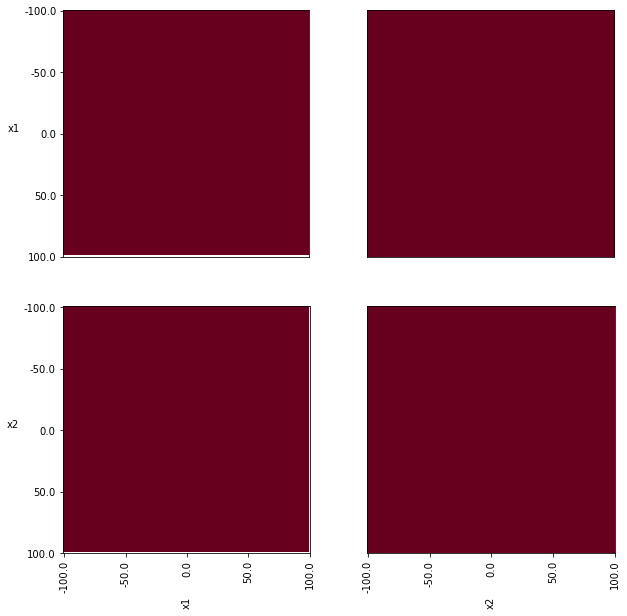

In [2]:
tomograph = ModelTomograph(optimizer=optimizer)
tomograph.plot()

In [3]:
# Let's train the optimizer a bit to make it plot interesting stuff.
#
params_df = objective_function.parameter_space.random_dataframe(100)
objectives_df = objective_function.evaluate_dataframe(params_df)
optimizer.register(params_df, objectives_df)

In [4]:
optimizer.predict(objective_function.parameter_space.random_dataframe(5))

objective_name: y, dataframe.head(1): [{'is_valid_input': True, 'predicted_value': 83.28032502687655, 'predicted_value_variance': 4.4341169914506855, 'sample_variance': 22.170584557245242, 'sample_size': 10, 'predicted_value_degrees_of_freedom': 40}]

{
  "x1": -47.99873177117067,
  "x2": -18.750487302393864
}


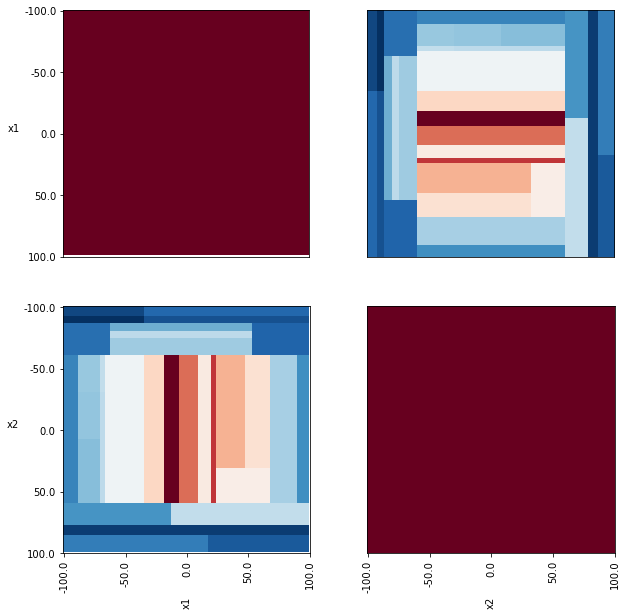

In [5]:
tomograph = ModelTomograph(optimizer=optimizer)
tomograph.plot()

In [18]:
# OK, so we have a trained optimizer and a tomograph, we can now start messing with the plot function.
#
import numpy as np
import pandas as pd

def plot(tomograph, point=None):
    if point is None:
        point = tomograph.optimizer.optimization_problem.parameter_space.random()
    print(point)
    tomograph._update_heatmaps(point, time=None)
    
    # Let's grab all of the observations to plot them.
    #
    registered_params_df, registered_objectives_df, context_df = optimizer.get_all_observations()
    
    fig = make_subplots(rows=tomograph.num_plottable_dimensions, cols=tomograph.num_plottable_dimensions)
    
    for row, heatmap_row in enumerate(tomograph._heatmaps_grid):
        for col, heatmap in enumerate(heatmap_row):
            row_dim_name = tomograph.ordered_dim_names[row]
            col_dim_name = tomograph.ordered_dim_names[col]
            
            if row == col:
                # We must manually create the query dataframe.
                #                
                query_df = pd.DataFrame({row_dim_name: tomograph.linspaces_by_name[row_dim_name]})
                
                for dim_name in tomograph.ordered_dim_names:
                    if dim_name != row_dim_name:
                        query_df[dim_name] = point[dim_name] if dim_name in point else np.NaN
                
                predictions = tomograph.optimizer.predict(query_df)
                predictions_df = predictions.get_dataframe()                
                fig.add_trace(
                    go.Scatter(
                        x=query_df[row_dim_name],
                        y=predictions_df['predicted_value']
                    ),
                    row=row+1,
                    col=col+1
                )
                
                # Add scatterplot over the top
                #
                fig.add_trace(
                    go.Scatter(
                        x=registered_params_df[row_dim_name],
                        y=registered_objectives_df[optimizer.optimization_problem.objectives[0].name],
                        mode='markers'
                    ),
                    row=row+1,
                    col=col+1
                )
                
                # Add titles
                #
                fig.update_xaxes(title_text=row_dim_name, row=row + 1, col=col + 1)
                fig.update_yaxes(title_text=col_dim_name, row=row + 1, col=col + 1)
                
            else:
                # Plot the heatmap.
                #
                fig.add_trace(
                    go.Heatmap(
                        x=tomograph.linspaces_by_name[row_dim_name],
                        y=tomograph.linspaces_by_name[col_dim_name],
                        z=heatmap.values
                    ),
                    row=row+1,
                    col=col+1
                )
                
                # Add scatterplot over the top
                #
                fig.add_trace(
                    go.Scatter(
                        x=registered_params_df[row_dim_name],
                        y=registered_params_df[col_dim_name],
                        mode='markers'
                    ),
                    row=row+1,
                    col=col+1
                )
                
                # Add titles
                #
                fig.update_xaxes(title_text=row_dim_name, row=row + 1, col=col + 1)
                fig.update_yaxes(title_text=col_dim_name, row=row + 1, col=col + 1)
                
    fig.show()

plot(tomograph)

{
  "x1": -56.87758637995086,
  "x2": -95.77288550759904
}


In [10]:
help(go.Heatmap)

Help on class Heatmap in module plotly.graph_objs._heatmap:

class Heatmap(plotly.basedatatypes.BaseTraceType)
 |  Heatmap(arg=None, autocolorscale=None, coloraxis=None, colorbar=None, colorscale=None, connectgaps=None, customdata=None, customdatasrc=None, dx=None, dy=None, hoverinfo=None, hoverinfosrc=None, hoverlabel=None, hoverongaps=None, hovertemplate=None, hovertemplatesrc=None, hovertext=None, hovertextsrc=None, ids=None, idssrc=None, legendgroup=None, meta=None, metasrc=None, name=None, opacity=None, reversescale=None, showlegend=None, showscale=None, stream=None, text=None, textsrc=None, transpose=None, uid=None, uirevision=None, visible=None, x=None, x0=None, xaxis=None, xcalendar=None, xgap=None, xperiod=None, xperiod0=None, xperiodalignment=None, xsrc=None, xtype=None, y=None, y0=None, yaxis=None, ycalendar=None, ygap=None, yperiod=None, yperiod0=None, yperiodalignment=None, ysrc=None, ytype=None, z=None, zauto=None, zhoverformat=None, zmax=None, zmid=None, zmin=None, zsmoo

In [ ]:
registered_params_df